# Problem description:
<br>

### We start with the well-known “Zachary’s karate club” problem. The karate club is a social network which captures 34 members and document pairwise links between members who interact outside the club. The club later divides into two communities led by the instructor (node 0) and the club president (node 33)

# Step 1) Creating the graph for Zachary’s karate club

In [31]:
import dgl
%matplotlib inline
import matplotlib.pyplot as plt

def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

In [2]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


## Visualize the graph

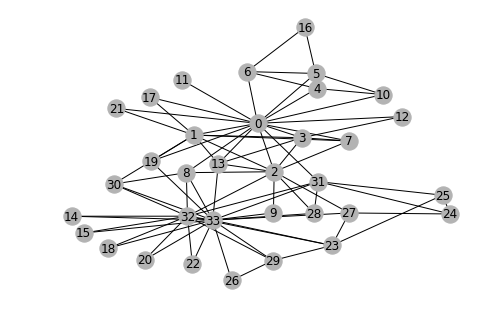

In [5]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 2) assign features to nodes or edges
<br>

### Graph neural networks associate features with nodes and edges. In DGL, we can add features for all nodes at once, using a feature tensor that has #nodes  rows 

In [6]:
import torch

G.ndata['feat'] = torch.eye(34)# 34x34 identity matrix 

# Step 3: define a Graph Convolutional Network (GCN)
<br>

- At layer *l* each node $v_i^l$ carries a feature vector $h_i^l$
- Each layer of the GCN tries to aggregate the features from $u^l_i$ where $u_i$‘s are neighborhood nodes to *v* into the next layer representation at $v^{l+1}_i$
- This is followed by an affine transformation with some non-linearity.
<br>

In general, the nodes send information computed via the message functions, and aggregates incoming information with the reduce functions.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message & reduce function
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [8]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 2)

# Step 4: data preparation and initialization
<br>

### We use one-hot vectors to initialize the node features. Since this is a semi-supervised setting, only the instructor (node 0) and the club president (node 33) are assigned labels

In [9]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

# Step 5: train then visualize



In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7102
Epoch 1 | Loss: 0.6138
Epoch 2 | Loss: 0.5312
Epoch 3 | Loss: 0.4487
Epoch 4 | Loss: 0.3677
Epoch 5 | Loss: 0.2931
Epoch 6 | Loss: 0.2212
Epoch 7 | Loss: 0.1575
Epoch 8 | Loss: 0.1035
Epoch 9 | Loss: 0.0630
Epoch 10 | Loss: 0.0357
Epoch 11 | Loss: 0.0197
Epoch 12 | Loss: 0.0110
Epoch 13 | Loss: 0.0064
Epoch 14 | Loss: 0.0039
Epoch 15 | Loss: 0.0024
Epoch 16 | Loss: 0.0016
Epoch 17 | Loss: 0.0011
Epoch 18 | Loss: 0.0008
Epoch 19 | Loss: 0.0006
Epoch 20 | Loss: 0.0004
Epoch 21 | Loss: 0.0003
Epoch 22 | Loss: 0.0003
Epoch 23 | Loss: 0.0002
Epoch 24 | Loss: 0.0002
Epoch 25 | Loss: 0.0001
Epoch 26 | Loss: 0.0001
Epoch 27 | Loss: 0.0001
Epoch 28 | Loss: 0.0001
Epoch 29 | Loss: 0.0001


/anaconda3/lib/python3.6/site-packages/dgl/frame.py:204: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  dgl_warning('Initializer is not set. Use zero initializer instead.'


<IPython.core.display.Javascript object>


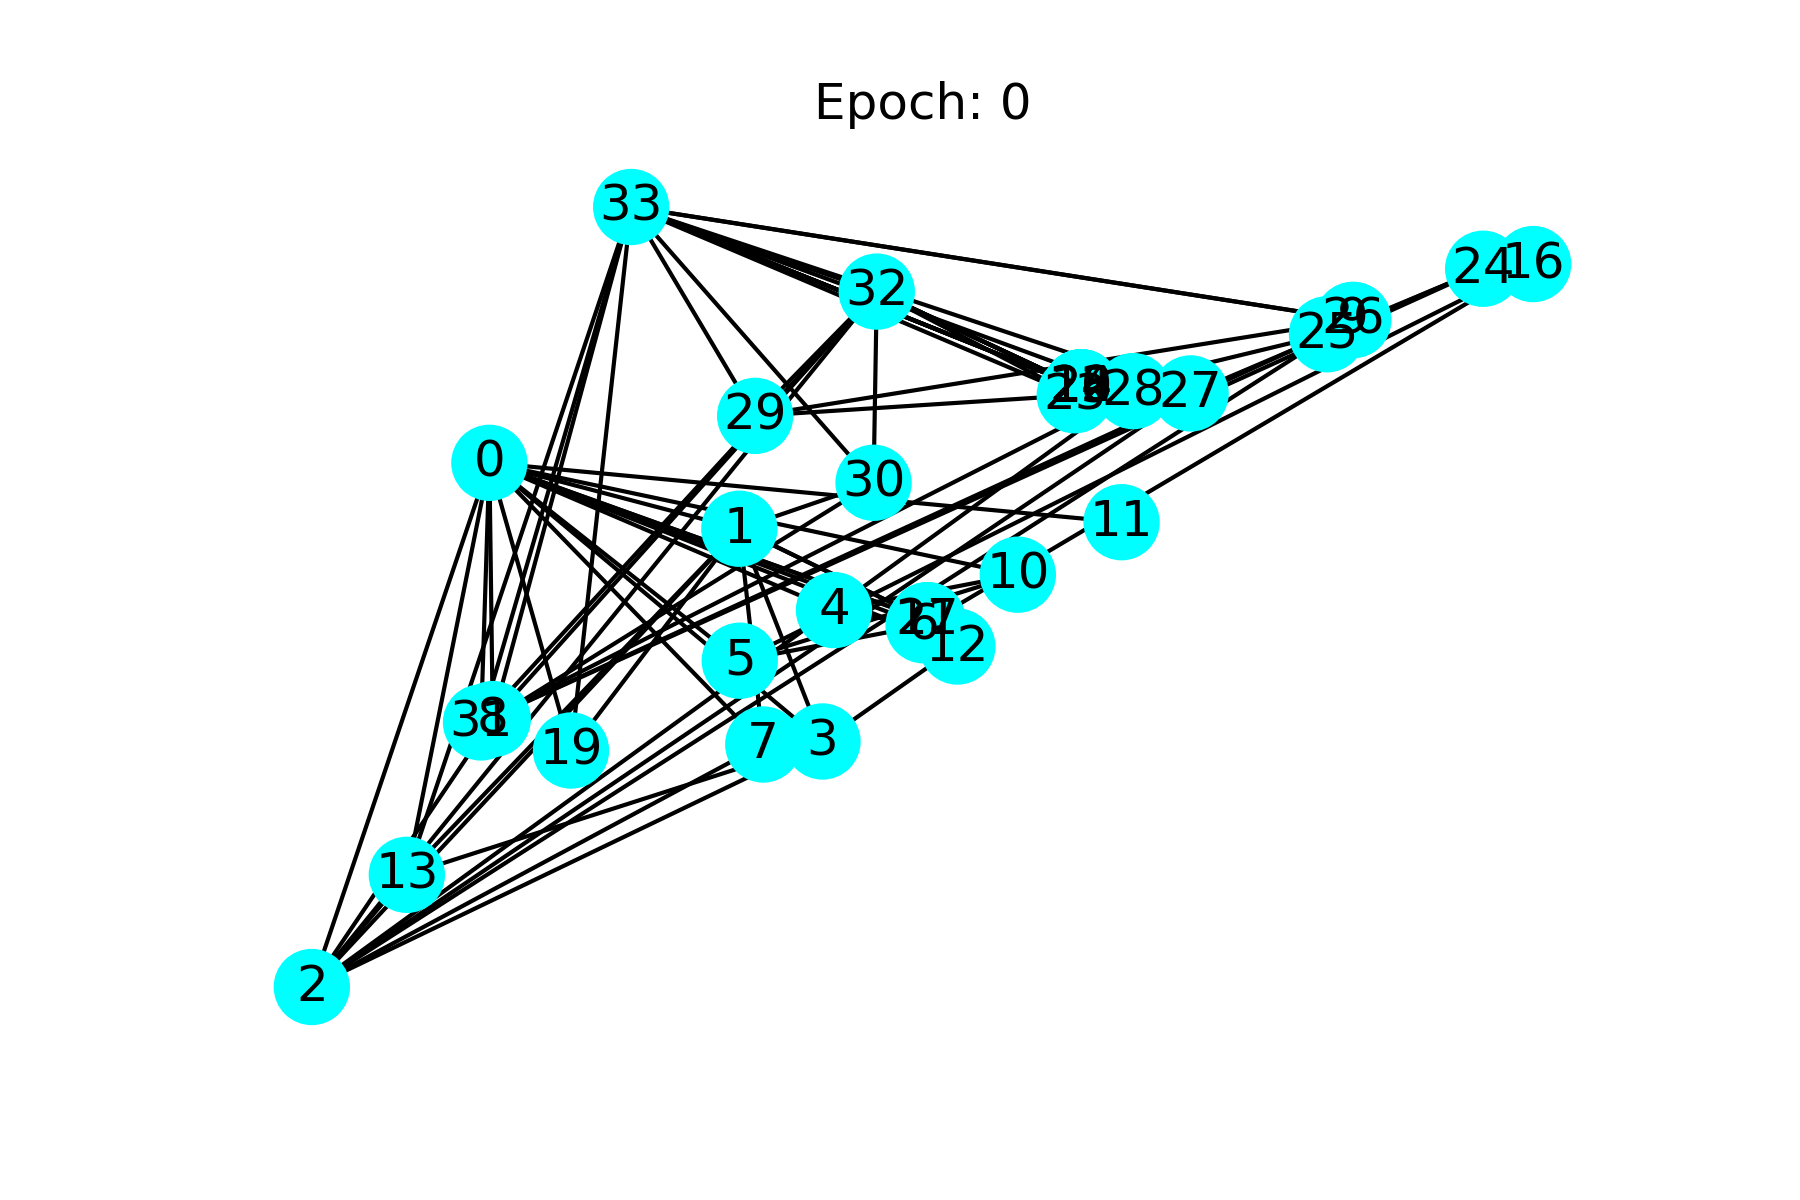

In [61]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
#plt.close()

In [60]:
from IPython.display import HTML
HTML(ani.to_html5_video())
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=300)